In [29]:
!pip install seaborn

     |████████████████████████████████| 292 kB 1.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [31]:
import os
from itertools import count

import shapefile
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas
import osmnx as ox
import pandas as pd
from tqdm.auto import tqdm
from libpysal.cg import voronoi_frames
import momepy
import math
import shapely
shapely.speedups.disable()

import seaborn as sns

sns.set_theme(context='poster', style="whitegrid")

DATA = "data"

In [3]:
G = nx.read_gpickle(os.path.join(DATA, "spiw_peripheral_bike_and_investmap.gpickle"))
G=G.to_undirected()

In [4]:
for u, v, data in G.edges(data=True):
    if data["type"]=='closest_crossing':
        data["type"]='all_road'


In [5]:
buildings=[node for node in G.nodes if G.nodes[node]["type"]=="building"]

In [6]:
bike_crossings=[node for node in G.nodes if G.nodes[node]["type"]=="bike_crossing"]

In [7]:
H = nx.Graph(((u, v, e) for u,v,e in G.edges(data=True) if e['type'] == 'all_road'))

In [8]:
def path_length(G, path): 
    return sum([list(dict(G[path[i]][path[i+1]]).values())[0]['length'] for i in range(len(path)-1)])

In [9]:
for u,v,e in tqdm(G.edges(data=True)):
    if e['type'] == 'bike_path':
        pt1=shapely.geometry.Point(G.nodes[u]['x'],G.nodes[u]['y'] )
        pt2=shapely.geometry.Point(G.nodes[v]['x'],G.nodes[v]['y'])
        points_df = geopandas.GeoDataFrame({'geometry': [pt1, pt2]}, crs='EPSG:4326').to_crs("EPSG:2177")
        e["length"]=points_df.distance(points_df.shift())[1]
#         print(points_df.distance(points_df.shift())[1])


  0%|          | 0/116896 [00:00<?, ?it/s]

In [14]:
path_from_building_to_bike_lengths = []


for b in tqdm(buildings):
    shortest_paths=nx.shortest_path(G, source=b,  weight='length') 
    not_bike=[node for node in shortest_paths.keys() if G.nodes[node]["type"]!="bike_crossing" and G.nodes[node].get("additional")!="new_bike_path"]
    for n in not_bike:
        shortest_paths.pop(n, None)
    shortest_path=(math.inf, math.inf)
    for key, shortest_tmp in shortest_paths.items():
        shortest_length=path_length(G,shortest_tmp)
        if shortest_length<shortest_path[1]:
            shortest_path=(shortest_tmp,shortest_length)
            
    path_from_building_to_bike_lengths.append(shortest_path[1])
    
    for i in range(len(shortest_path[0])-1):
        list(dict(G[shortest_path[0][i]][shortest_path[0][i+1]]).values())[0]['additional']="new_bike_path"
        G.nodes[shortest_path[0][i]]["additional"]="new_bike_crossing"
        
    G.nodes[shortest_path[0][len(shortest_path[0])-1]]["additional"]="new_bike_crossing"

  0%|          | 0/1481 [00:00<?, ?it/s]

In [25]:
# nx.write_gpickle(G, "shortest_paths.gpickle")

## Długości nowych ścieżek

In [23]:
records = []
for node, length in zip(buildings, path_from_building_to_bike_lengths):
    record = {
        'name': G.nodes[node]['name'],
        'x': G.nodes[node]['x'],
        'y': G.nodes[node]['y'],
        'length_to_bikenet': length
    }
    records.append(record)

In [26]:
df = pd.DataFrame.from_records(records)

In [32]:
df.head()

name        x        y  \
0                                    Aura Bielany  16.9692  51.0395   
1                                Quart Bielany II  16.9674  51.0443   
2  Osiedle domów jednorodzinnych, ul. Porzeczkowa  16.9599  51.0340   
3                               Osiedle Słoneczne  16.9630  51.0163   
4                               Osiedle Kameralne  16.9684  51.0298   

   length_to_bikenet  
0        1750.000482  
1        1187.441528  
2        2616.803874  
3        5068.266402  
4        3350.232487

In [33]:
df.to_csv(os.path.join(DATA, 'investments_to_bike_net.csv'), index=False)

In [36]:
df['lenght_km'] = df['length_to_bikenet'].apply(lambda d: d/1000)

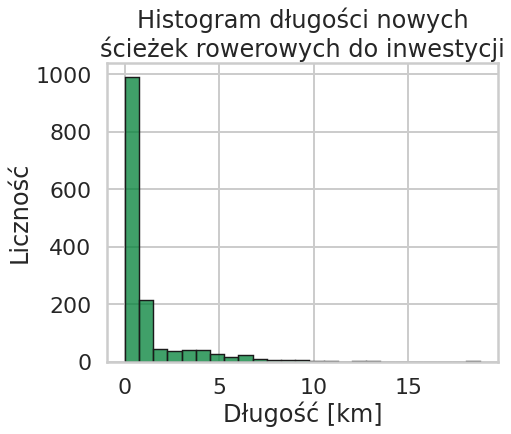

In [151]:
fig, ax = plt.subplots(figsize=(7, 5.5))
sns.histplot(x='lenght_km', data=df, ax=ax, bins=25, edgecolor='k', color='#008037')
ax.set_title('Histogram długości nowych\nścieżek rowerowych do inwestycji')
ax.set_xlabel('Długość [km]')
ax.set_ylabel('Liczność')
fig.savefig('image/length_histogram.png', dpi=400, transparent=True, bbox_inches='tight')

In [52]:
total_length = 0
for u,v,a in G.edges(data=True):
    if 'additional' in a.keys() and a['additional'] == 'new_bike_path':
         total_length += a['length']

In [56]:
df['length_to_bikenet'].sum() / 1000

1882.3279891563118

In [55]:
total_length / 1000

653.8667797675932

Różna długość całkowita, chyba ta druga bardziej poprawna, bo nie uwzględnia nakładania się.

## Wizualizacja

In [58]:
G_nodes, G_streets = ox.graph_to_gdfs(G)

G_nodes = G_nodes.to_crs(epsg=2177)
G_streets = G_streets.to_crs(epsg=2177)

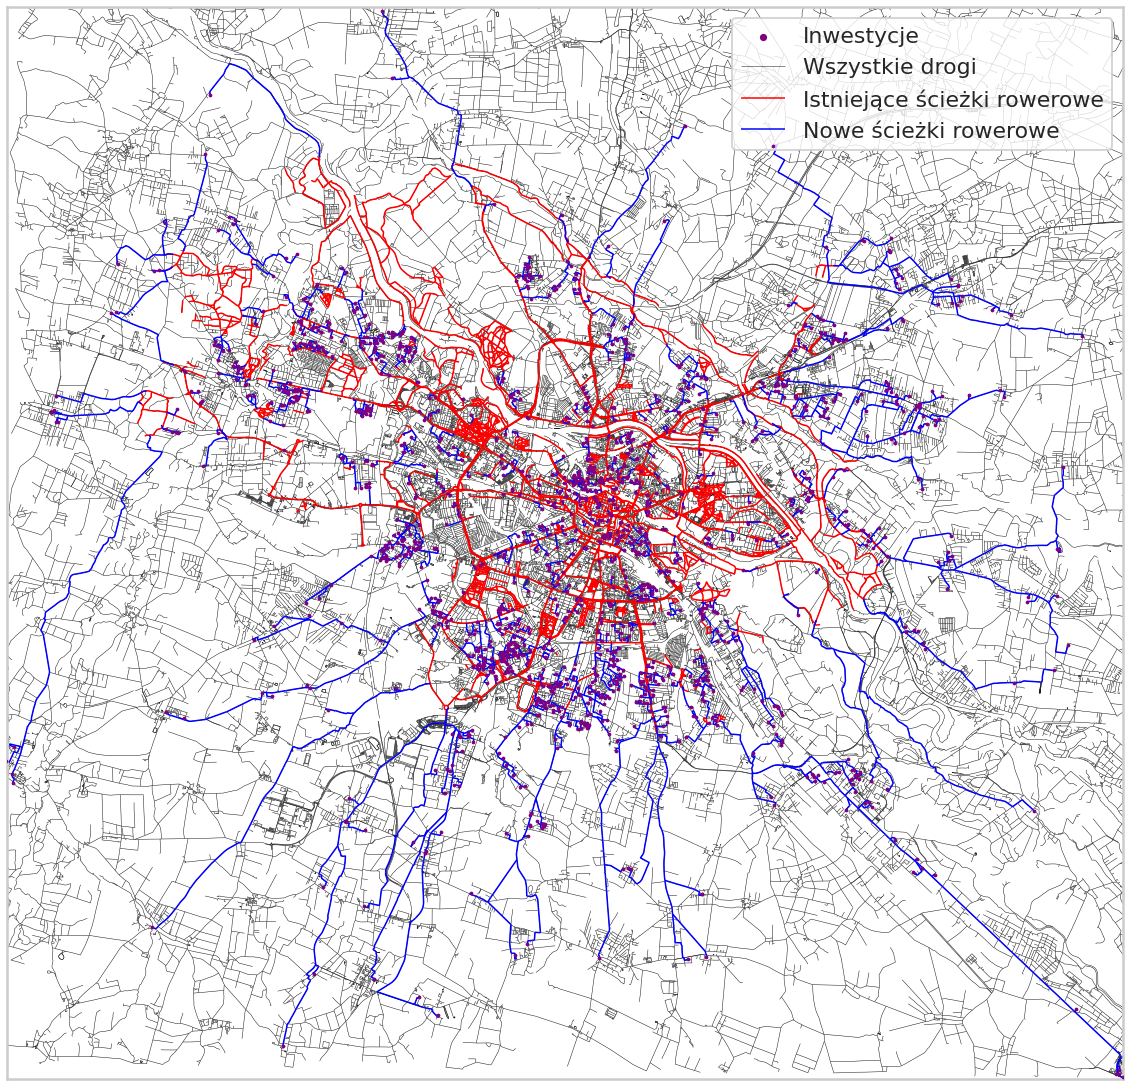

In [130]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot()

# G_nodes[G_nodes['type'] == 'bike_crossing'].plot(markersize=1, color='red', ax=ax)
# G_nodes[G_nodes['type'] == 'road_crossing'].plot(markersize=0.1, color='green', ax=ax)
G_nodes[G_nodes['type'] == 'building'].plot(
    markersize=3, color='purple', ax=ax, zorder=7, label='Inwestycje'
)

G_streets[G_streets['type'] == 'all_road'].plot(
    ax=ax, alpha=1, linewidth=0.5, edgecolor='k', label='Wszystkie drogi'
)
G_streets[G_streets['type'] == 'bike_path'].plot(
    ax=ax, alpha=1, linewidth=1.5, edgecolor='red', label='Istniejące ścieżki rowerowe'
)
G_streets[G_streets.get('additional') == 'new_bike_path'].plot(
    ax=ax, alpha=1, linewidth=1.5, edgecolor='blue', label='Nowe ścieżki rowerowe'
)

ax.legend(markerscale=3)

ax.set_ylim(bottom=5.6461e6, top=5.6803e6)
ax.set_xlim(left=6.4134e6, right=6.449e6)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('image/shortest_paths_adjusted_no_cx.jpg', dpi=400, bbox_inches='tight')
# cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)
# plt.savefig('image/shortest_paths.jpg')

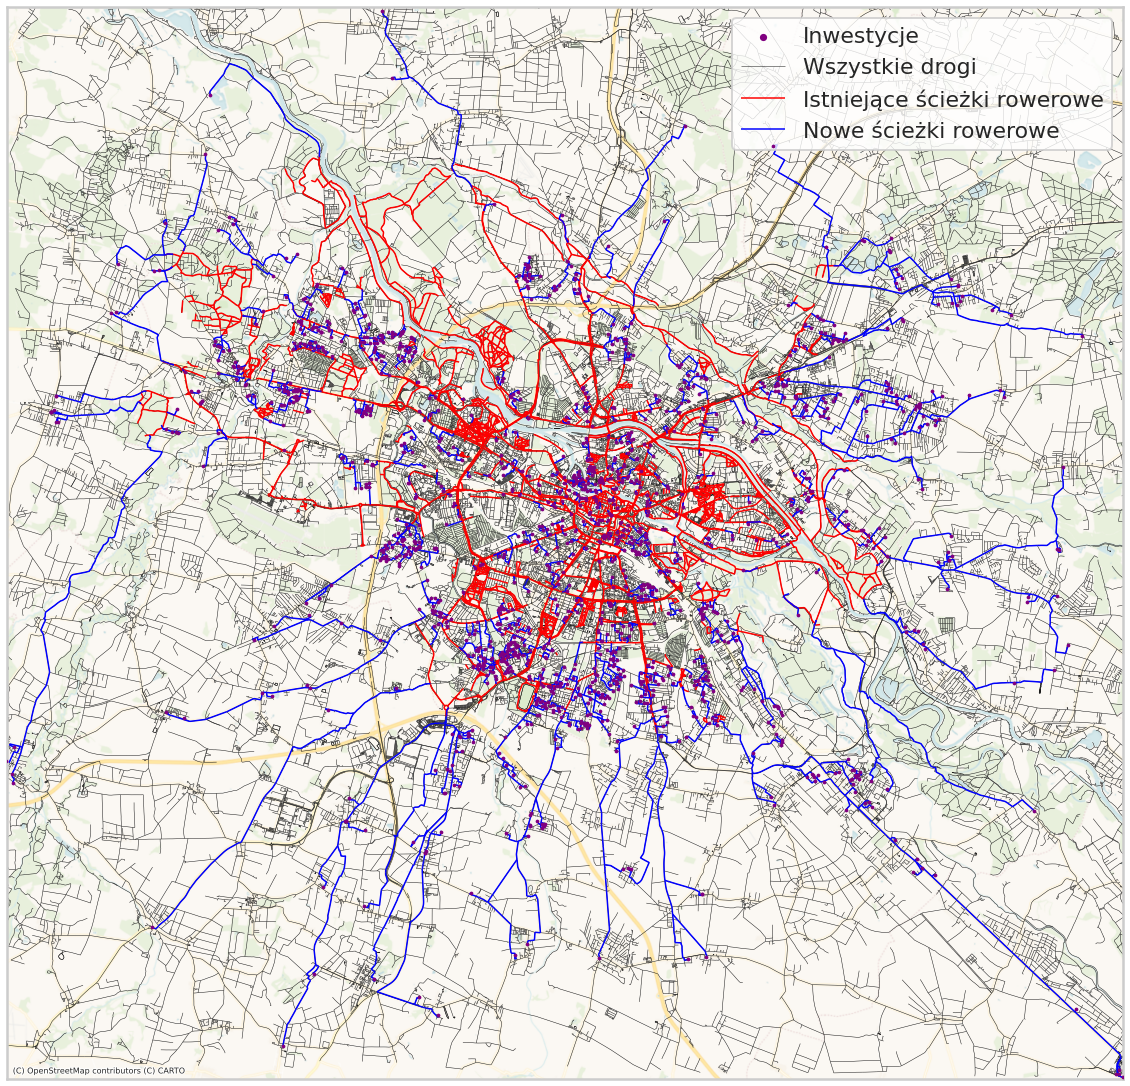

<Figure size 432x288 with 0 Axes>

In [131]:
cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)
fig.savefig('image/shortest_paths_adjusted.jpg', dpi=400, bbox_inches='tight')
fig